<a href="https://colab.research.google.com/github/mutouyu1124/time-series-example/blob/master/Stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fbprophet

In [0]:
!pip install pytrends

In [0]:
!pip install pytrends

In [3]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fbprophet
import pytrends
from pytrends.request import TrendReq

from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [0]:
class Stock(object):
  # initialize the stock data
  def __init__(self,ticker):
    
    ticker = ticker.upper()
    
    self.symbol = ticker
    
    quandl.ApiConfig.api_key = 'saU3Kye_asAxvpXoxUC_'
    # Retrieval the financial data
    try:
      stock = quandl.get('WIKI/%s'%ticker)
    except Exception as e:
      print('Error Retrieving Data')
      print(e)
      return
    # Set the index to a column called Date
    stock = stock.reset_index(level=0)
    # Columns required for prophet
    stock['ds'] = stock['Date']
    stock['y'] = stock['Adj. Close']
    # Data assigned as class attribute
    self.stock = stock
    # Minimum and maximum date in range
    self.min_date = np.min(stock['ds'])
    self.max_date = np.max(stock['ds'])
    # This can be changed by user
    self.changepoint_prior_scale = 0.2
    
    print('{} Stocker initialized, Data covers from {} to {}'.format(self.symbol,self.min_date.date(),self.max_date.date()))

  # Basic Historical Plot
  def plot(self,start_date = None, end_date = None):
    
    if not start_date:
      start_date = self.min_date
    if not end_date:
      end_date = self.max_date
    
    # Convert to pandas date time
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    # Check to make sure dates are in the data
    if start_date.date() > end_date.date():
      print('Start date must be later than end date')
      return
    
    if (start_date not in list(self.stock['ds'])):
      print('Start Date not in data (either out of range or not a trading day.)')
      return
    elif (end_date not in list(self.stock['ds'])):
      print('End Date not in data (either out of range or not a trading day.)')
      return
    
    stock_plot = self.stock[(self.stock['ds'] >= start_date.date())&(self.stock['ds'] <= end_date.date())]
    
    plt.style.use('seaborn-notebook')
    plt.plot(stock_plot['ds'], stock_plot['y'],color='b',linewidth = 1)
    plt.title("{} Stock Price from {} to {}".format(self.symbol,start_date.date(),end_date.date()))
    plt.ylabel('Closing Price($)')
  
  # Create a prophet model without training
  def __create_model(self,**kwargs):
    # Make the model
    model = fbprophet.Prophet(daily_seasonality = False, weekly_seasonality = False,
                              changepoint_prior_scale = self.changepoint_prior_scale,
                              **kwargs)
    model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
    
    return model
  
  # Method to linearly interpolate prices on the weekends
  def __resampling(self, dataframe):
    # Change the index and resample at daily level
    dataframe = dataframe.reset_index('ds')
    dataframe = dataframe.resample('D')
    # Reset the index and interpolate nan values
    dataframe = dataframe.reset_index(level = 0)
    dataframe = dataframe.interpolate()
    
    return dataframe
  
  # Remove weekends from a dataframe
  def __remove_weekends(self, dataframe):
    # Reset index to use ix
    dataframe = dataframe.reset_index(drop=True)
        
    weekends = []
        
    # Find all of the weekends
    for i, date in enumerate(dataframe['ds']):
      if (date.weekday()) == 5 | (date.weekday() == 6):
        weekends.append(i)
            
    # Drop the weekends
    dataframe = dataframe.drop(weekends, axis=0)
        
    return dataframe
  
  # Train Prophet model and plot the fitted values
  def create_prophet_model(self, years = 5, resample = False):
    
    # Set how many years of historical data used to train model 
    self.years = years
    
    stock_history = self.stock[self.stock['ds'] > (self.max_date - pd.DateOffset(years = self.years)).date()]
    
    model = self.__create_model()
    
    if resample:
      stock_history = self.__resampling(stock_history)
    # Train model and fit for observations
    model.fit(stock_history)
    future = model.make_future_dataframe(periods=0, freq='D')
    predictions = future.copy()
    mp = model.predict(future)
    # Design result dataframe
    predictions['yhat_upper'] = mp['yhat_upper']
    predictions['yhat_lower'] = mp['yhat_lower']
    predictions['yhat'] = mp['yhat']
    # Plot the fitted results
    plt.style.use('seaborn-notebook')
    fig,ax = plt.subplots(1,1)
    ax.plot(stock_history['ds'],stock_history['y'],color='b',label = 'Observations')
    ax.plot(predictions['ds'],predictions['yhat'],linewidth = 1,label='Fitted',color="red")
    ax.fill_between(predictions['ds'].dt.to_pydatetime(), predictions['yhat_upper'],predictions['yhat_lower'],alpha = 0.3, facecolor='red', edgecolor = 'k', linewidth = 0.6)
    plt.legend(loc='best')
    plt.ylabel('Closing Price($)')
    plt.title('{} Stock Price'.format(self.symbol))
    plt.show()
    return model, predictions  
  
  # Using trained model to predict future and analysis results
  def predict_feature(self, model, days = 365, resample = False):
    
    # Used for plot
    stock_history = self.stock[self.stock['ds'] > (self.max_date - pd.DateOffset(years = self.years)).date()]
    # Making predictions
    future = model.make_future_dataframe(periods = days, freq = 'D')
    future = model.predict(future)
    
    future_ = future[future['ds'] > self.max_date.date()]
    # Remove weekends
    future_ = self.__remove_weekends(future_)

    trading_days = future_.shape[0]
    # Analysis results
    future_['diff'] = future_['yhat'].diff()
    
    future_ = future_.dropna()
    
    future_['direction'] = (future_['diff']>0)*1
    
    future_ = future_.rename(columns = {'ds':'Date','yhat':'Estimate','diff':'change','yhat_upper':'upper','yhat_lower':'lower'})
    
    num_day_increase = future_[future_['direction'] == 1].shape[0]
    num_day_decrease = trading_days - num_day_increase
    
    print("Among {} days, {} days are trading days".format(days,trading_days))
    print("Among {} trading days, {} days are predicted increasing, {} days are predicted decreasing".format(trading_days,num_day_increase,num_day_decrease))
    
    # Plot future prediction with confidence interval
    plt.style.use('seaborn-notebook')
    fig,ax = plt.subplots(1,1)
    ax.plot(stock_history['ds'],stock_history['y'],color='b',label = 'Observations')
    ax.plot(future['ds'],future['yhat'],linewidth = 1,label='Fitted',color="red")
    ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'],future['yhat_lower'],alpha = 0.3, facecolor='red', edgecolor = 'k', linewidth = 0.6,label = 'Uncertainty')
    plt.vlines(x=self.max_date.date(), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                   linestyles='dashed', label = 'Prediction Start')
    plt.legend(loc='best')
    plt.ylabel('Closing Price($)')
    plt.title('{} Stock Price'.format(self.symbol))
    plt.show()
    
    return future_
  
  # Split data into training and test, train model with training data and evaluate result on test data
  def train_prophet_model(self,years,metrics = 'rmse'):
    
    start_date = self.max_date - pd.DateOffset(years = 1)
    # Obtain training and test day. Default we use last 1 year as test data, last 3 years as training data.
    train = self.stock[(self.stock['ds'] < start_date.date()) &(self.stock['ds'] > (start_date - pd.DateOffset(years = years)).date())]
    test = self.stock[self.stock['ds'] >= start_date.date()]
    
    eval_days = (max(test['ds'])-min(test['ds'])).days
    # Build model and fit
    model = self.__create_model()
    model.fit(train)
    # Making prediction on test data
    future = model.make_future_dataframe(periods = eval_days,freq = 'D')
    future = model.predict(future)
    # Evaluate results
    train_results = pd.merge(train,future[['ds','yhat','yhat_upper','yhat_lower']],on='ds',how='inner')
    if metrics == 'rmse':
      ave_train_error = np.sqrt(np.mean(np.square(train_results['y'] - train_results['yhat'])))
    elif metrics == 'mae':
      ave_train_error = np.mean(abs(train_results['y'] - train_results['yhat']))
    
    test_results = pd.merge(test,future[['ds','yhat','yhat_upper','yhat_lower']],on='ds',how='inner')
    if metrics == 'rmse':
      ave_test_error = np.sqrt(np.mean(np.square(test_results['y'] - test_results['yhat'])))
    elif metrics == 'mae':
      ave_test_error = np.mean(abs(test_results['y'] - test_results['yhat']))
    
    print("Under the metrics {}, the training error: {}, the test error: {}".format(metrics, round(ave_train_error,4),round(ave_test_error,4)))    
    # Plot the reuslts
    plt.style.use('seaborn-notebook')
    fig,ax = plt.subplots(1,1)
    ax.plot(train['ds'],train['y'],color='b',label = 'Observations')
    ax.plot(test['ds'],test['y'],color='b') 
    ax.plot(future['ds'],future['yhat'],linewidth = 1,label='Fitted',color="red")
    ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'],future['yhat_lower'],alpha = 0.3, facecolor='yellow', edgecolor = 'k', linewidth = 0.6,label = 'Uncertainty')
    plt.vlines(x=start_date.date(), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                   linestyles='dashed', label = 'Prediction Start')
    plt.legend(loc='best')
    plt.ylabel('Closing Price($)')
    plt.title('{} Stock Price'.format(self.symbol))
    plt.show()
  
  # Tune changepoint_prior_scale by validation method
  def changepoint_prior_scale_validation(self,changepoint_prior_scale = [0.01,0.1,0.3,0.5],metrics = 'rmse'):
    
    start_date = self.max_date - pd.DateOffset(years = 1)
    
    train = self.stock[(self.stock['ds'] < start_date.date()) &(self.stock['ds'] > (start_date - pd.DateOffset(years = 3)).date())]
    test = self.stock[self.stock['ds'] >= start_date.date()]
    
    eval_days = (max(test['ds'])-min(test['ds'])).days
    
    results = pd.DataFrame(0,index=list(range(len(changepoint_prior_scale))), columns = ['cps', 'train_err','test_err'])
    
    for i,prior in enumerate(changepoint_prior_scale):
      results.ix[i, 'cps'] = prior
      self.changepoint_prior_scale = prior
      model = self.__create_model()
      model.fit(train)
    
      future = model.make_future_dataframe(periods = eval_days,freq = 'D')
      future = model.predict(future)
    
      train_results = pd.merge(train,future[['ds','yhat','yhat_upper','yhat_lower']],on='ds',how='inner')
      if metrics == 'rmse':
        ave_train_error = np.sqrt(np.mean(np.square(train_results['y'] - train_results['yhat'])))
      elif metrics == 'mae':
        ave_train_error = np.mean(abs(train_results['y'] - train_results['yhat']))
    
      test_results = pd.merge(test,future[['ds','yhat','yhat_upper','yhat_lower']],on='ds',how='inner')
      if metrics == 'rmse':
        ave_test_error = np.sqrt(np.mean(np.square(test_results['y'] - test_results['yhat'])))
      elif metrics == 'mae':
        ave_test_error = np.mean(abs(test_results['y'] - test_results['yhat']))
      
      results.ix[i,'train_err'] = ave_train_error
      results.ix[i,'test_err'] = ave_test_error
    print(results)
    
    plt.style.use('seaborn-notebook')
    plt.plot(results['cps'],results['train_err'],'.-',color='b',label = "Train Error")
    plt.plot(results['cps'],results['test_err'],'.-',color='orange',label = "Test Error")
    plt.title('Training and Testing Curves as Function of CPS')
    plt.xticks(results['cps'], results['cps'])
    plt.legend(loc='best')
    plt.show()
  
  # Retrieval search frequency from google trends
  def retrieve_google_trends(self,term,date_range):
    # Set up the trend fetching object
    pytrends = TrendReq(hl='en-US', tz=360)
    kw_list = [term]
    self.term = term
    try:
      # Create the search object
      pytrends.build_payload(kw_list, cat=0, timeframe=date_range, geo='', gprop='')
            
      # Retrieve the interest over time
      trends = pytrends.interest_over_time()
    except Exception as e:
      print('\nGoogle Search Trend retrieval failed.')
      print(e)
      return
    
    trends = trends.resample('D')
    trends = trends.reset_index(level=0)
    trends = trends.rename(columns={'date':'ds',term:'freq'})
    trends['freq'] = trends['freq'].interpolate()
        
    return trends
  
  # Analysis chagepoint based on google trends
  def changepoint_analysis(self,model,trends):
    
    stock_history = self.stock[self.stock['ds'] > (self.max_date - pd.DateOffset(years = self.years)).date()]
    
    cp = model.changepoints
    # Create dataframe of only changepoints
    change_indices = []
    for changepoint in (cp):
      change_indices.append(self.stock[self.stock['ds'] == changepoint.date()].index[0])
  
    c_data = self.stock.ix[change_indices, :]
    deltas = model.params['delta'][0]
    c_data['delta'] = deltas
    c_data['abs_delta'] = abs(c_data['delta'])
    # Sort the values by maximum change
    c_data = c_data.sort_values(by='abs_delta', ascending=False)
#     print('\nChangepoints sorted by slope rate of change (2nd derivative):\n')
#     print(c_data.ix[:, ['Date', 'Adj. Close', 'delta']][:5])
    
    plt.style.use('seaborn-notebook')
    data_merge = pd.merge(stock_history, trends, on = 'ds', how = 'inner')
    # Normalize values
    data_merge['y_norm'] = data_merge['y'] / max(data_merge['y'])
    data_merge['freq_norm'] = data_merge['freq'] / max(data_merge['freq'])
    plt.plot(data_merge['ds'], data_merge['y_norm'], 'k-', label = 'Stock Price')
    plt.plot(data_merge['ds'], data_merge['freq_norm'], color='forestgreen', label = 'Search Frequency')

    c_data_top10 = c_data[:10]

    plt.vlines(c_data_top10['ds'].dt.to_pydatetime(), ymin=0, ymax=1,
                   linewidth = 1.2, label='Changepoints', linestyles='dashed', color = 'r')
       
    # Plot formatting
    plt.legend(prop={'size': 10})
    plt.xlabel('Date'); plt.ylabel('Normalized Values'); plt.title('Stock Price and Search Frequency for the term %s' %self.term)
    plt.show()
    
    

In [80]:
chase = Stock(ticker = 'JPM')

JPM Stocker initialized, Data covers from 1983-12-30 to 2018-03-27


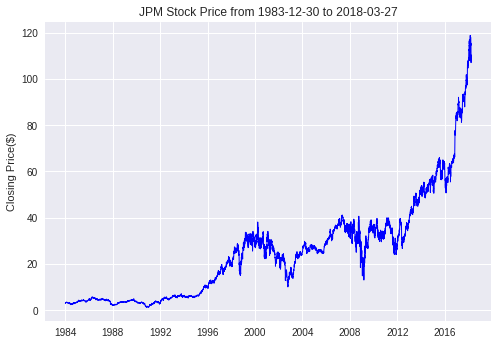

In [84]:
chase.plot()

In [0]:
chase.changepoint_prior_scale = 0.5

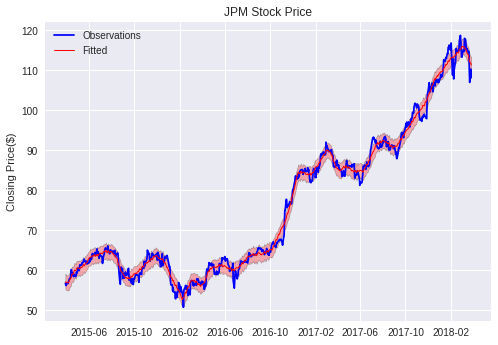

In [19]:
model,fitted = chase.create_prophet_model(years = 3)

Among 120 days, 103 days are trading days
Among 103 trading days, 42 days are predicted increasing, 61 days are predicted decreasing


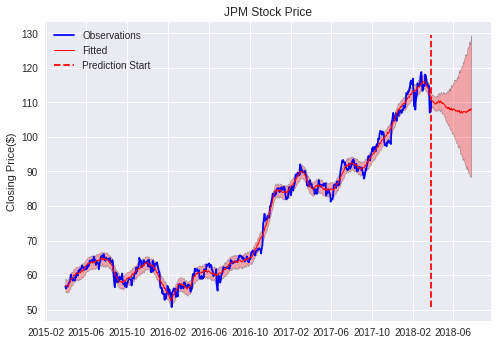

In [21]:
prediction = chase.predict_feature(model,days = 120)

Under the metrics rmse, the training error: 1.0748, the test error: 3.8876


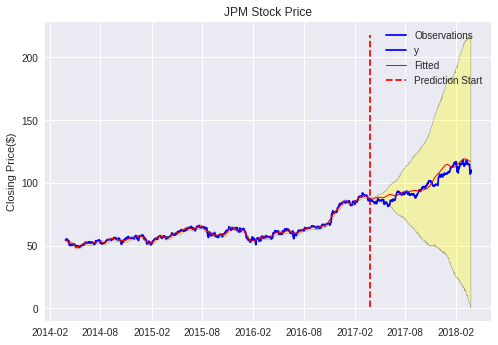

In [43]:
chase.train_prophet_model(years=3,metrics = 'rmse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:228: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


   cps  train_err   test_err
0  0.1   1.175937  10.150926
1  0.3   1.088337   4.923763
2  0.5   1.074842   3.887593
3  0.7   1.071412   3.586644
4  0.9   1.065843   3.253879


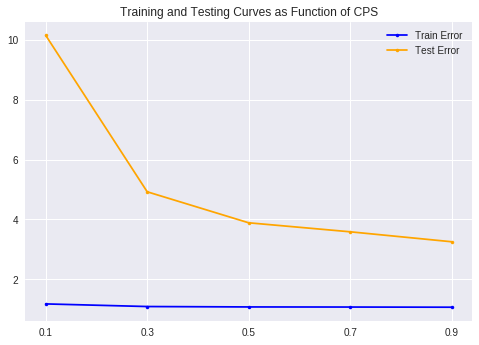

In [57]:
chase.changepoint_prior_scale_validation(changepoint_prior_scale=[0.1,0.3,0.5,0.7,0.9])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:228: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


    cps  train_err  test_err
0  0.90   1.065843  3.253879
1  0.93   1.066301  3.222110
2  0.95   1.065417  3.187545
3  0.97   1.067548  3.257691


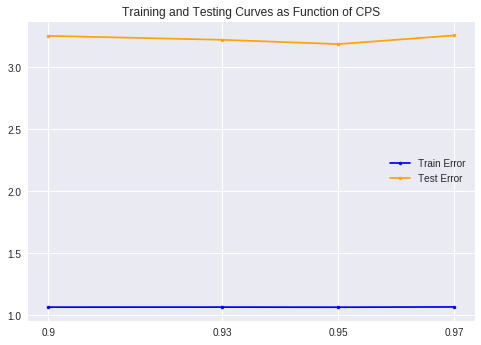

In [58]:
chase.changepoint_prior_scale_validation(changepoint_prior_scale=[0.9,0.93,0.95,0.97])

In [0]:
chase.changepoint_prior_scale_validation=0.95

Under the metrics rmse, the training error: 1.0675, the test error: 3.2577


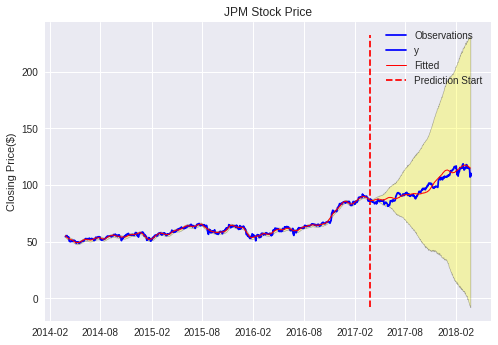

In [60]:
chase.train_prophet_model(years=3,metrics = 'rmse')

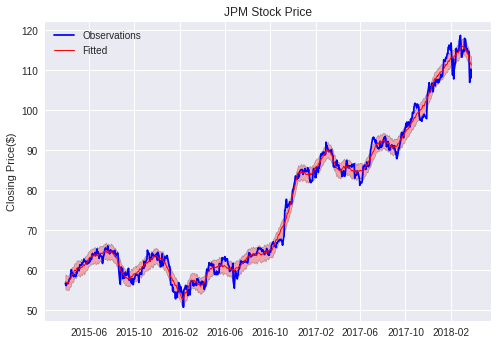

In [81]:
model,fitted = chase.create_prophet_model(years = 3)

Among 120 days, 103 days are trading days
Among 103 trading days, 42 days are predicted increasing, 61 days are predicted decreasing


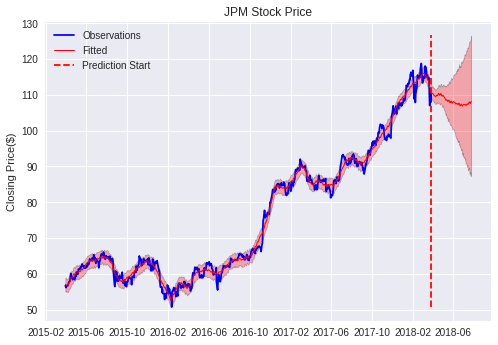

In [82]:
prediction = chase.predict_feature(model,days = 120)

In [83]:
trends = chase.retrieve_google_trends(term='JPMorgan Chase & Co',date_range='2012-01-01 2018-04-01')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:277: FutureWarning: 
.resample() is now a deferred operation
You called reset_index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead


In [84]:
trends.head()

,ds,freq,isPartial
0,2012-01-01,64.000000,0.0
1,2012-01-02,63.064516,NaN
2,2012-01-03,62.129032,NaN
3,2012-01-04,61.193548,NaN
4,2012-01-05,60.258065,NaN


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


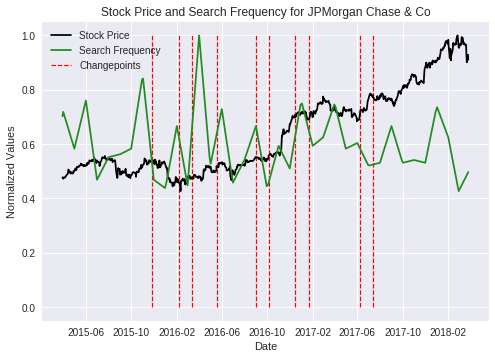

In [85]:
chase.changepoint_analysis(model,trends)

In [89]:
chase.stock.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,ds,y
0,1983-12-30,44.00,44.50,43.50,44.00,47000.0,0.0,1.0,3.074327,3.109262,3.039391,3.074327,211500.0,1983-12-30,3.074327
1,1984-01-03,43.94,44.25,43.62,44.00,85667.0,0.0,1.0,3.070135,3.091795,3.047776,3.074327,385501.5,1984-01-03,3.074327
2,1984-01-04,44.84,45.87,44.25,45.87,65000.0,0.0,1.0,3.133019,3.204986,3.091795,3.204986,292500.0,1984-01-04,3.204986
3,1984-01-05,46.81,47.38,46.25,47.38,76467.0,0.0,1.0,3.270665,3.310491,3.231537,3.310491,344101.5,1984-01-05,3.310491
4,1984-01-06,46.88,47.38,46.38,46.88,43200.0,0.0,1.0,3.275556,3.310491,3.240620,3.275556,194400.0,1984-01-06,3.275556


In [0]:
class Stock_LSTM(object):
  # initialize the stock data
  def __init__(self,ticker):
    
    ticker = ticker.upper()
    
    self.symbol = ticker
    
    quandl.ApiConfig.api_key = 'saU3Kye_asAxvpXoxUC_'
    
    try:
      stock = quandl.get('WIKI/%s'%ticker)
    except Exception as e:
      print('Error Retrieving Data')
      print(e)
      return
    
    stock = stock.reset_index(level=0)
    
    stock['ds'] = stock['Date']
    stock['y'] = stock['Adj. Close']
    
    self.stock = stock
    
    self.min_date = np.min(stock['ds'])
    self.max_date = np.max(stock['ds'])
    
    self.lb = 7
    
    print('{} Stocker initialized, Data covers from {} to {}'.format(self.symbol,self.min_date.date(),self.max_date.date()))

  def plot(self,start_date = None, end_date = None):
    
    if not start_date:
      start_date = self.min_date
    if not end_date:
      end_date = self.max_date
      
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.date() > end_date.date():
      print('Start date must be later than end date')
      return
    
    if (start_date not in list(self.stock['ds'])):
      print('Start Date not in data (either out of range or not a trading day.)')
      return
    elif (end_date not in list(self.stock['ds'])):
      print('End Date not in data (either out of range or not a trading day.)')
      return
    
    stock_plot = self.stock[(self.stock['ds'] >= start_date.date())&(self.stock['ds'] <= end_date.date())]
    
    plt.style.use('seaborn-notebook')
    plt.plot(stock_plot['ds'], stock_plot['y'],color='b',linewidth = 1)
    plt.title("{} Stock Price from {} to {}".format(self.symbol,start_date.date(),end_date.date()))
    plt.ylabel('Closing Price($)')
    
  def create_LSTM_model(self,units = 64):
    
    model = Sequential()
    model.add(LSTM(units,input_shape = (self.lb,1)))
    model.add(Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mse')
    return model
  
  def __processData(self,data):
    
    X,y = [],[]
    
    for i in range(len(data) - self.lb -1):
      X.append(data[i:(i+self.lb),0])
      y.append(data[(i+self.lb),0])
      
    return np.array(X),np.array(y)
    
    
  def train_LSTM_model(self,model,epochs = 300):
    stock_history = self.stock[self.stock['ds'] > (self.max_date - pd.DateOffset(years = 4)).date()]
    
    data = stock_history['y'].values
    
    scl = MinMaxScaler()
    data = data.reshape(data.shape[0],1)
    data = scl.fit_transform(data)
    
    X, y = self.__processData(data)
    
    X_train, X_test = X[:int(X.shape[0]*0.75)], X[int(X.shape[0]*0.75):]
    y_train, y_test = y[:int(y.shape[0]*0.75)], y[int(y.shape[0]*0.75):]
    
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    
    print("Start training LSTM model...")
    history = model.fit(X_train,y_train,epochs = epochs,verbose = 0, validation_data = (X_test,y_test), shuffle = False)
    print("Training process is done.")
    
    plt.style.use('seaborn-notebook')
    plt.figure(figsize = (16,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['loss'], label = "Training Loss")
    plt.plot(history.history['val_loss'], label = "Validation_Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss function")
    plt.legend(loc='best')
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_pred  = scl.inverse_transform(train_pred)
    test_pred = scl.inverse_transform(test_pred)
    
    plt.subplot(2,2,2)
    Xt = model.predict(X_test)
    plt.plot(scl.inverse_transform(y_test.reshape(-1,1)),color='k',label="original series")
    plt.plot(scl.inverse_transform(Xt),color='r',label="predicted series")
    plt.title("Prediction of Stock Price on Test Set")
    plt.legend(loc='best')
    
    plt.subplot(2,2,3)
    plt.plot(scl.inverse_transform(y.reshape(-1,1)), color='k')
    
    split_pt = int(X.shape[0]*0.75) # window_size
    plt.plot(np.arange(0,split_pt,1), train_pred, color='b')
    plt.plot(np.arange(split_pt,split_pt+len(test_pred),1), test_pred, color='r')

    plt.xlabel('day')
    plt.ylabel('Stock Prics($)')
    plt.title('Stock Price of {}'.format(self.symbol))
    plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    train_mse = np.sqrt(np.mean(np.square(train_pred - y_train)))
    test_mse = np.sqrt(np.mean(np.square(train_pred - y_test)))
         
    print("Training rmse error: {}, test rmse error: {}".format(train_mse,test_mse))
    
    return model
  
  def prediction_future(self,model,days = 180):
    stock_history = self.stock[self.stock['ds'] > (self.max_date - pd.DateOffset(years = 4)).date()]
    
    data = stock_history['y'].values
    
    scl = MinMaxScaler()
    data = data.reshape(data.shape[0],1)
    data = scl.fit_transform(data)
    
    x, y = self.__processData(data)
    
    X = data[-self.lb:]
    X = X.reshape((1,X.shape[0],1))
    
    prediction = []
    
    for i in range(days): 
      pred = model.predict(X)
      X = np.concatenate((X, pred), axis=None)
      X = X[1:]
      X = np.reshape(X,(-1, 1))
      X = X.reshape((1,X.shape[0],1))
      pred = scl.inverse_transform(pred.reshape(1,-1))
      prediction = np.concatenate((prediction, pred), axis=None)
      
    
    plt.style.use('seaborn-notebook')
    split_pt = x.shape[0]
    plt.plot(np.arange(0,split_pt,1),scl.inverse_transform(y.reshape(-1,1)), color='k',label="Observations")
    plt.plot(np.arange(split_pt,split_pt+days,1),prediction,color = 'r',label="Predict future")
    plt.title("Predict Future Stock Price by Trained Model")
    plt.xlabel('days')
    plt.ylabel('Stock Price($)')
    plt.legend(loc="best")

    

In [15]:
chase = Stock_LSTM(ticker = 'JPM')

JPM Stocker initialized, Data covers from 1983-12-30 to 2018-03-27


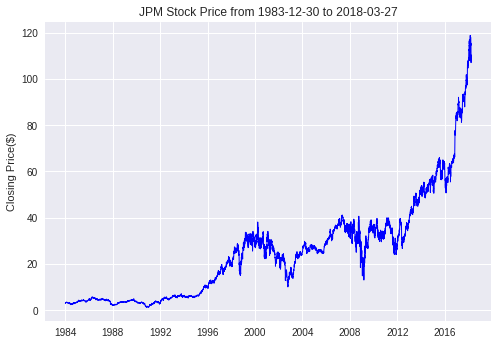

In [99]:
chase.plot()

In [0]:
model = chase.create_LSTM_model()

Start training LSTM model...
Training process is done.


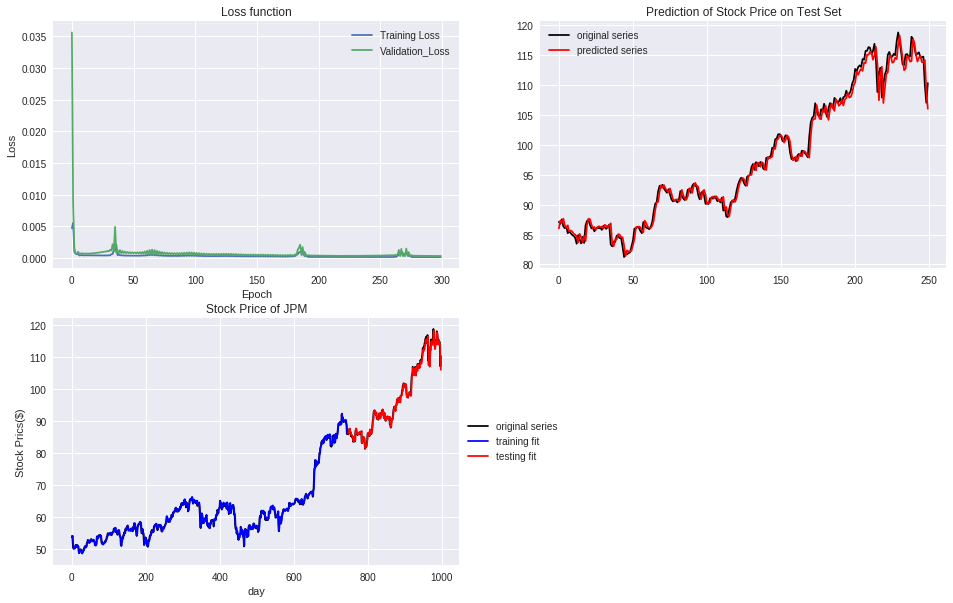

Training rmse error: 62.29783239115616, test rmse error: 61.79403903526071


In [23]:
lstm = chase.train_LSTM_model(model,epochs = 300)

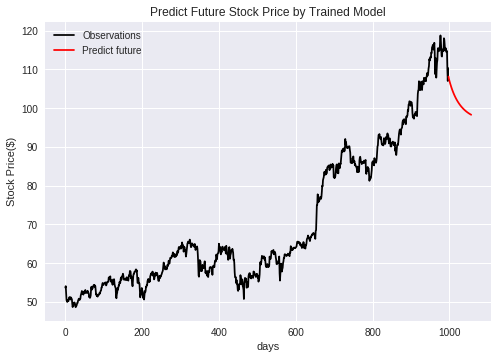

In [24]:
chase.prediction_future(lstm,days = 60)